In [136]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import random
import pdb
import csv
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32
MAX_SENTENCE_LENGTH = 30

In [137]:
train_loss_history = {}
train_acc_history={}
validation_acc_history = {}
final_val_acc ={}

# read SNLI data

In [138]:
train_dir = './snli_train.tsv'
val_dir = './snli_val.tsv'
def read_data(path):
    with open(path) as f:
        premise =[]
        hypothesis =[]
        labels =[]
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            premise.append(row[0])
            hypothesis.append(row[1])
            labels.append(row[2])
        premise= premise[1:]; hypothesis=hypothesis[1:]; labels=labels[1:]     
    return premise, hypothesis, labels

In [139]:
train_premise,train_hypothesis, train_labels= read_data(train_dir)
val_premise, val_hypothesis, val_labels = read_data(val_dir)

# load Fasttext pre-trained embedding

In [140]:
words_to_load = 100000
with open( './wiki-news-300d-1M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load, 300))
    words = {}
    idx2words = {}
    ordered_words = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i, :] = np.asarray(s[1:])
        words[s[0]] = i
        idx2words[i] = s[0]
        ordered_words.append(s[0])


# tokenization

In [141]:
def tokenize_dataset(dataset):
    token_dataset = []
    all_tokens = []
    for sentence in dataset:
        tokens = sentence.split(' ')
        token_dataset.append(tokens)
        all_tokens += tokens
    return token_dataset, all_tokens
print ("Tokenizing val premesie")
val_premise_tokens, _ = tokenize_dataset(val_premise)
print("Tokenizing val hypothesis")
val_hypothesis_tokens, _ = tokenize_dataset(val_hypothesis)

print ("Tokenizing train premise")
train_premise_tokens, all_train_premise_tokens = tokenize_dataset(train_premise)
print("Tokenizing train hypothesis")
train_hypothesis_tokens, all_train_hypothesis_tokens = tokenize_dataset(train_hypothesis)


Tokenizing val premesie
Tokenizing val hypothesis
Tokenizing train premise
Tokenizing train hypothesis


# Build vocabulary + token2id

In [142]:
def build_vocab(data):

    max_len = max([len(sentence) for sentence in data])
    all_tokens = []
    for sentence in data:
        all_tokens += sentence.split(' ')
    unique_token = list(set(all_tokens))
    id2token = unique_token
    token2id = dict(zip(unique_token, range(2,2+len(unique_token)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token, max_len

def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


In [143]:
all_train_data = all_train_premise_tokens + all_train_hypothesis_tokens
token2id, id2token, max_len = build_vocab(all_train_data)

In [144]:
train_premise_indices = token2index_dataset(train_premise_tokens)
train_hypothesis_indices = token2index_dataset(train_hypothesis_tokens)
val_premise_indices = token2index_dataset(val_premise_tokens)
val_hypothesis_indices = token2index_dataset(val_hypothesis_tokens)
labels = {'neutral': 0,'entailment':1, 'contradiction':2 }
train_labels_indices=[labels[i] for i in train_labels]
val_labels_indices = [labels[i] for i in val_labels]

# embedding weight matrix

In [145]:
embedding_weight_matrix = np.zeros((len(token2id), 300))
for i, token in enumerate(id2token):
    #give unknown and pad embedding
    if i==0 or i ==1:
        embedding_weight_matrix[i]=np.zeros(300)
    elif token not in words:
        embedding_weight_matrix[i]=np.zeros(300)
    else:
        embedding_weight_matrix[i]=loaded_embeddings[words[token]]
embedding_weight_matrix = torch.from_numpy(np.array(embedding_weight_matrix))

# DataLoader

In [146]:
class SNLIData(Dataset):

    def __init__(self, premise_list, hypothesis_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.premise_list = premise_list
        self.hypothesis_list = hypothesis_list
        self.target_list = target_list
        assert (len(self.premise_list) == len(self.target_list))
        assert (len(self.hypothesis_list) == len(self.target_list))

    def __len__(self):
        return len(self.premise_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """ 
        premise_idx = self.premise_list[key][:MAX_SENTENCE_LENGTH]
        hypothesis_idx= self.hypothesis_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [premise_idx, hypothesis_idx, len(premise_idx),len(hypothesis_idx), label]



In [147]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    premise_list = []
    hypothesis_list = []
    label_list = []
    premise_length_list = []
    hypothesis_length_list = []

    for datum in batch:
        label_list.append(datum[-1])
        premise_length_list.append(datum[2])
        hypothesis_length_list.append(datum[3])
        
    # padding
    for datum in batch:
        
        padded_premise = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        
        premise_list.append(padded_premise)
        padded_hypothesis = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        hypothesis_list.append(padded_hypothesis)
        
    if torch.cuda.is_available and torch.has_cudnn:
        return [torch.from_numpy(np.array(premise_list)).cuda(), torch.from_numpy(np.array(hypothesis_list)).cuda(),
                    torch.LongTensor(premise_length_list).cuda(), torch.LongTensor(hypothesis_length_list).cuda(), torch.LongTensor(label_list).cuda()]
    else:
        return [torch.from_numpy(np.array(premise_list)), torch.from_numpy(np.array(hypothesis_list)),
                torch.LongTensor(premise_length_list), torch.LongTensor(hypothesis_length_list),torch.LongTensor(label_list)]


In [148]:

train_dataset = SNLIData(train_premise_indices, train_hypothesis_indices, train_labels_indices)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = SNLIData(val_premise_indices, val_hypothesis_indices, val_labels_indices)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)



# Paramters below are used to tune later

In [218]:
hidden_dim = 250
rnn = True
dropout_value = 0
kernal_size = 4
linear_size = 32

def paramter_combnination_name(rnn, hidden_size,dropout, kernal_size, linear_size):
    if rnn:
        name = 'rnn'+'_hidden_dim_'+str(hidden_dim)+'_dropout_'+str(dropout_value)+'_linear_size_'+str(linear_size)
    else:
        name = 'cnn'+'_hidden_dim_'+str(hidden_dim)+'_dropout_'+str(dropout_value)+\
        '_kernal_size_'+str(kernal_size)+'_linear_size_'+str(linear_size)
        
    return name

current_parameter_setting = paramter_combnination_name(rnn, hidden_dim, dropout_value, kernal_size, linear_size)
train_loss_history[current_parameter_setting]=[]
validation_acc_history[current_parameter_setting]=[]
train_acc_history[current_parameter_setting]=[]
print(current_parameter_setting)

rnn_hidden_dim_250_dropout_0_linear_size_32


# RNN model

In [219]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, linear_size, dropout_value):
    
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(embedding_weight_matrix, freeze=True)
        self.gru= nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(hidden_size*2, linear_size)
        self.linear_2 = nn.Linear(linear_size, num_classes)
        self.dropout = nn.Dropout(p=dropout_value)

    def init_hidden(self, batch_size):
        if torch.cuda.is_available and torch.has_cudnn:
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size).cuda()
        else:
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        return hidden
    

    def forward(self, premise, hypothesis, pre_length, hyp_length):
        # reset hidden state
        batch_size, seq_len_premise = premise.size()
        batch_size, seq_len_hypothesis = hypothesis.size()

        self.hidden = self.init_hidden(batch_size)
        
         # compute sorted sequence lengths
        _, idx_sort_1 = torch.sort(pre_length, dim=0, descending=True)
        _, idx_sort_2 = torch.sort(hyp_length, dim=0, descending=True)
        _, idx_unsort_1 = torch.sort(idx_sort_1, dim=0)
        _, idx_unsort_2 = torch.sort(idx_sort_2, dim=0)
        
        # get embedding of characters
        embed_1 = self.embedding(premise).float()
        embed_2 = self.embedding(hypothesis).float()
        # sort embeddings and lengths
        embed_1 = embed_1.index_select(0,idx_sort_1)
        embed_2 = embed_2.index_select(0,idx_sort_2)
        len1 = list(pre_length[idx_sort_1])
        len2 = list(hyp_length[idx_sort_2])
        
        # pack padded sequence
        embed_1 = torch.nn.utils.rnn.pack_padded_sequence(embed_1, np.array(len1), batch_first=True)
        embed_2 = torch.nn.utils.rnn.pack_padded_sequence(embed_2, np.array(len2), batch_first=True)
        
        # fprop though RNN
        _, hidden_1 = self.gru(embed_1, self.hidden)
        _, hidden_2 = self.gru(embed_2, self.hidden)
        
        # sum the hidden state on the first dimension
        hidden_1 = torch.sum(hidden_1, dim=0)
        hidden_2 = torch.sum(hidden_2, dim=0)
        
        # unsort the hidden state and concatenate the two
        hidden_1 = hidden_1.index_select(0, idx_unsort_1)
        hidden_2 = hidden_2.index_select(0, idx_unsort_2)
        
        concat_input = torch.cat((hidden_1, hidden_2), dim=1)
        output = self.linear_1(concat_input)
        output = self.relu(output)
        output = self.dropout(output)
        logits = self.linear_2(output)
        return logits



In [220]:
def test_rnn_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    rnn_best_result =[]
    for premise, hypothesis, pre_length, hyp_length, labels in loader:
        premise_batch, hypothesis_batch = premise, hypothesis
        pre_length_batch, hyp_length_batch, labels_batch =pre_length, hyp_length, labels
        outputs = F.softmax(model(premise_batch, hypothesis_batch, pre_length_batch, hyp_length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        #store best results after tunning all paramters
        rnn_best_result.append([labels.cpu().numpy(), predicted.cpu().numpy().reshape(-1)])
    return (100 * correct / total), rnn_best_result


model = RNN(emb_size=300, hidden_size=hidden_dim, num_layers=1, num_classes=3, linear_size=linear_size, dropout_value=dropout_value)
if torch.cuda.is_available and torch.has_cudnn:
    model.cuda()
learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (premise, hypothesis, pre_length, hyp_length, labels) in enumerate(train_loader):
        model.train()
        premise_batch, hypothesis_batch = premise, hypothesis
        pre_length_batch, hyp_length_batch, labels_batch =pre_length, hyp_length, labels
        optimizer.zero_grad()
        # Forward pass
        outputs = model(premise, hypothesis, pre_length, hyp_length)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 500 iterations
        if i > 0 and i % 500 == 0:
            # validate
            val_acc,_= test_rnn_model(val_loader, model)
            train_acc,_ = test_rnn_model(train_loader, model)
            train_acc_history[current_parameter_setting].append(train_acc)
            validation_acc_history[current_parameter_setting].append(val_acc)
            train_loss_history[current_parameter_setting].append(loss.item())
            
            print('Epoch: [{}/{}], Step: [{}/{}], Loss: {} Train Acc: {} Val Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss.item(), train_acc, val_acc))


Epoch: [1/10], Step: [501/3125], Loss: 1.0659722089767456 Train Acc: 54.453 Val Acc: 55.1
Epoch: [1/10], Step: [1001/3125], Loss: 1.042068600654602 Train Acc: 57.719 Val Acc: 58.3
Epoch: [1/10], Step: [1501/3125], Loss: 0.9148475527763367 Train Acc: 58.961 Val Acc: 58.0
Epoch: [1/10], Step: [2001/3125], Loss: 0.9327008128166199 Train Acc: 59.71 Val Acc: 59.1
Epoch: [1/10], Step: [2501/3125], Loss: 0.9126183390617371 Train Acc: 60.327 Val Acc: 58.3
Epoch: [1/10], Step: [3001/3125], Loss: 0.7342974543571472 Train Acc: 61.022 Val Acc: 60.0
Epoch: [2/10], Step: [501/3125], Loss: 0.7179995179176331 Train Acc: 61.732 Val Acc: 60.9
Epoch: [2/10], Step: [1001/3125], Loss: 0.8799462914466858 Train Acc: 62.088 Val Acc: 61.4
Epoch: [2/10], Step: [1501/3125], Loss: 0.7686986923217773 Train Acc: 62.488 Val Acc: 60.1
Epoch: [2/10], Step: [2001/3125], Loss: 0.7615606784820557 Train Acc: 63.647 Val Acc: 63.3
Epoch: [2/10], Step: [2501/3125], Loss: 1.1123454570770264 Train Acc: 63.904 Val Acc: 64.8
Epo

In [221]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_rnn_model(val_loader, model)[0]))

final_val_acc[current_parameter_setting]= test_rnn_model(val_loader, model)[0]

After training for 10 epochs
Val Acc 70.6


In [79]:
# Save
# np.save('train_acc_history.npy', train_acc_history)
# np.save('validation_acc_history.npy', validation_acc_history)
# np.save('train_loss_history.npy', train_loss_history)
# np.save('final_val_acc.npy', final_val_acc)

# Load
read_vali_acc = np.load('validation_acc_history.npy').item()
read_train_loss = np.load('train_loss_history.npy').item()
read_after_acc = np.load('final_val_acc.npy').item()

In [80]:
read_after_acc

{'rnn_hidden_dim_200_dropout_0': 69.7,
 'rnn_hidden_dim_200_dropout_0.2': 69.4,
 'rnn_hidden_dim_200_dropout_0.5': 66.6,
 'rnn_hidden_dim_300_dropout_0_linear_size_32': 69.1,
 'rnn_hidden_dim_100_dropout_0_linear_size_32': 69.4,
 'rnn_hidden_dim_150_dropout_0_linear_size_32': 68.6,
 'rnn_hidden_dim_250_dropout_0_linear_size_32': 70.6,
 'rnn_hidden_dim_250_dropout_0_linear_size_64': 69.9,
 'rnn_hidden_dim_250_dropout_0_linear_size_128': 69.6}

# CNN Model


In [174]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, linear_size, dropout_value):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size, self.linear_size = num_layers, hidden_size, linear_size
        self.embedding = nn.Embedding.from_pretrained(embedding_weight_matrix, freeze=True)
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.linear_1 = nn.Linear(hidden_size*2, linear_size)
        self.linear_2 = nn.Linear(linear_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_value)

    def forward(self, premise, hypothesis, pre_lengths, hyp_lengths):
        
        batch_size, seq_pre_len = premise.size()
        batch_size, seq_hyp_len = hypothesis.size()
        # get embedding of characters
        embed_pre = self.embedding(premise).float()
        embed_hyp = self.embedding(hypothesis).float()
        #fprop though CNN
        hidden_pre = self.conv1(embed_pre.transpose(1,2)).transpose(1,2)
        hidden_pre = F.relu(hidden_pre.contiguous().view(-1, hidden_pre.size(-1))).view(batch_size, seq_pre_len, hidden_pre.size(-1))
        hidden_pre = self.conv2(hidden_pre.transpose(1,2)).transpose(1,2)
        hidden_pre = F.relu(hidden_pre.contiguous().view(-1, hidden_pre.size(-1))).view(batch_size, seq_pre_len, hidden_pre.size(-1))
        pre_pool = torch.max(hidden_pre, dim=1)[0]
        
        hidden_hyp = self.conv1(embed_hyp.transpose(1,2)).transpose(1,2)
        hidden_hyp = F.relu(hidden_hyp.contiguous().view(-1, hidden_hyp.size(-1))).view(batch_size, seq_hyp_len, hidden_hyp.size(-1))
        hidden_hyp = self.conv2(hidden_hyp.transpose(1,2)).transpose(1,2)
        hidden_hyp = F.relu(hidden_hyp.contiguous().view(-1, hidden_hyp.size(-1))).view(batch_size, seq_hyp_len, hidden_hyp.size(-1))
        hyp_pool = torch.max(hidden_hyp, dim=1)[0]
        
        #concate hidden layer
        concat_input = torch.cat((pre_pool, hyp_pool), dim=1)
        output = self.linear_1(concat_input)
        output = self.relu(output)
        output = self.dropout(output)
        logits = self.linear_2(output)
        return logits
    

In [175]:
def test_cnn_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    cnn_best_result=[]
    model.eval()
    for premise, hypothesis, pre_length, hyp_length, labels in loader:
        premise_batch, hypothesis_batch = premise, hypothesis
        pre_length_batch, hyp_length_batch, labels_batch =pre_length, hyp_length, labels
        outputs = F.softmax(model(premise_batch, hypothesis_batch, pre_length_batch, hyp_length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        cnn_best_result.append([labels.cpu().numpy(), predicted.cpu().numpy().reshape(-1)])
    return (100 * correct / total), cnn_best_result


model = CNN(emb_size=300, hidden_size=hidden_dim, num_layers=2, num_classes=3, linear_size = linear_size, dropout_value=dropout_value)
if torch.cuda.is_available and torch.has_cudnn:
    model.cuda()
learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (premise, hypothesis, pre_length, hyp_length, labels) in enumerate(train_loader):
        model.train()
        premise_batch, hypothesis_batch = premise, hypothesis
        pre_length_batch, hyp_length_batch, labels_batch =pre_length, hyp_length, labels
        optimizer.zero_grad()
        # Forward pass
        outputs = model(premise, hypothesis, pre_length, hyp_length)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 500 iterations
        if i > 0 and i % 500 == 0:
            # validate
            val_acc,_ = test_cnn_model(val_loader, model)
            train_acc,_ = test_cnn_model(train_loader, model)
            train_acc_history[current_parameter_setting].append(train_acc)
            validation_acc_history[current_parameter_setting].append(val_acc)
            train_loss_history[current_parameter_setting].append(loss.item())
            
            print('Epoch: [{}/{}], Step: [{}/{}], Loss: {} Train Acc: {} Val Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss.item(), train_acc, val_acc))


Epoch: [1/10], Step: [501/3125], Loss: 0.8920600414276123 Train Acc: 57.333 Val Acc: 57.2
Epoch: [1/10], Step: [1001/3125], Loss: 0.9043060541152954 Train Acc: 60.739 Val Acc: 59.3
Epoch: [1/10], Step: [1501/3125], Loss: 0.8352721333503723 Train Acc: 61.261 Val Acc: 60.0
Epoch: [1/10], Step: [2001/3125], Loss: 0.9846460819244385 Train Acc: 63.352 Val Acc: 61.7
Epoch: [1/10], Step: [2501/3125], Loss: 0.8897958993911743 Train Acc: 64.451 Val Acc: 59.8
Epoch: [1/10], Step: [3001/3125], Loss: 0.7540331482887268 Train Acc: 65.134 Val Acc: 62.4
Epoch: [2/10], Step: [501/3125], Loss: 0.7953107357025146 Train Acc: 66.402 Val Acc: 62.2
Epoch: [2/10], Step: [1001/3125], Loss: 0.7478994727134705 Train Acc: 66.772 Val Acc: 62.6
Epoch: [2/10], Step: [1501/3125], Loss: 0.6656258702278137 Train Acc: 67.372 Val Acc: 62.9
Epoch: [2/10], Step: [2001/3125], Loss: 0.7760056257247925 Train Acc: 67.95 Val Acc: 64.0
Epoch: [2/10], Step: [2501/3125], Loss: 0.8584191799163818 Train Acc: 66.723 Val Acc: 62.5
Ep

In [177]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_cnn_model(val_loader, model)[0]))

final_val_acc[current_parameter_setting] = test_cnn_model(val_loader, model)[0]

After training for 10 epochs
Val Acc 66.8


In [147]:
# Save
np.save('train_acc_history.npy', train_acc_history)
np.save('validation_acc_history.npy', validation_acc_history)
np.save('train_loss_history.npy', train_loss_history)
np.save('final_val_acc.npy', final_val_acc)


In [10]:
# Load
read_vali_acc = np.load('validation_acc_history.npy').item()
read_train_loss = np.load('train_loss_history.npy').item()
read_after_acc = np.load('final_val_acc.npy').item()

In [178]:
final_val_acc

{'rnn_hidden_dim_200_dropout_0': 69.7,
 'rnn_hidden_dim_200_dropout_0.2': 69.4,
 'rnn_hidden_dim_200_dropout_0.5': 66.6,
 'rnn_hidden_dim_300_dropout_0_linear_size_32': 69.1,
 'rnn_hidden_dim_100_dropout_0_linear_size_32': 69.4,
 'rnn_hidden_dim_150_dropout_0_linear_size_32': 68.6,
 'rnn_hidden_dim_250_dropout_0_linear_size_32': 70.6,
 'rnn_hidden_dim_250_dropout_0_linear_size_64': 69.9,
 'rnn_hidden_dim_250_dropout_0_linear_size_128': 69.6,
 'cnn_hidden_dim_250_dropout_0_kernal_size_3_linear_size_32': 64.7,
 'cnn_hidden_dim_250_dropout_0.2_kernal_size_3_linear_size_32': 67.2,
 'cnn_hidden_dim_250_dropout_0.5_kernal_size_3_linear_size_32': 64.7,
 'cnn_hidden_dim_250_dropout_0.3_kernal_size_3_linear_size_32': 67.4,
 'cnn_hidden_dim_250_dropout_0.3_kernal_size_4_linear_size_32': 67.7,
 'cnn_hidden_dim_250_dropout_0.3_kernal_size_5_linear_size_32': 66.4,
 'cnn_hidden_dim_200_dropout_0.3_kernal_size_4_linear_size_32': 65.9,
 'cnn_hidden_dim_300_dropout_0.3_kernal_size_4_linear_size_32': 66

# Plot Validation Accuracy 

In [297]:
f = plt.figure(figsize=(20,7))
def plot_acc_curve(setting, rnn):
    if setting == 'dropout':
        if rnn:
            fixed = 'rnn_hidden_dim_200_'
            title = 'Rnn Dropout Regularization'
        else:
            fixed = '_kernal_size_3_linear_size_32'
            title = 'Cnn Dropout Redularization'
    if setting == 'hidden_dim':
        if rnn:
            fixed = '_dropout_0_linear_size_32'
            title = 'Rnn Hidden Dimension'
            #keys.append('rnn_hidden_dim_200_dropout_0')  
        else:
            fixed = '_dropout_0.3_kernal_size_4_linear_size_32'
            title = 'Cnn Hidden Dimension'
    if setting == 'linear_size':
        fixed = 'rnn_hidden_dim_250_dropout_0_'
        title = 'Rnn Linear Size'
    if setting =='kernal_size':
        fixed ='cnn_hidden_dim_250_dropout_0.3_'
        title = 'Cnn Kernal Size'
    keys = [key for key in final_val_acc.keys() if fixed in key]
    keys.sort()
    train_acc_acc = [train_acc_history.get(i) for i in keys]
    value_val_acc = [validation_acc_history.get(i) for i in keys]
    final_val_Acc = [[str(i), final_val_acc.get(i)] for i in keys]

    ax1 = f.add_subplot(121)
    for i in range(len(keys)):
        ax1.plot(train_acc_acc[i], label = keys[i])
    ax1.set_ylabel('Training_accuracy')
    ax1.set_xlabel('iteration (in 5 hundreds)')
    ax1.set_title('Training Accuracy')
    ax1.legend(loc=4)

    ax2 = f.add_subplot(122, sharey=ax1)
    for i in range(len(keys)):
        ax2.plot(value_val_acc[i], label =keys[i])
    ax2.set_ylabel('Validation Acc')
    ax2.set_xlabel('iteration (in 5 hundreds)')
    ax2.set_title('Validation Accuracy')
    ax2.legend(loc=4)

    f.suptitle(title, fontsize=32)
    #print final_val accuracy
    if setting == 'dropout':
        columns_name = [x[0].replace(fixed, '') for x in final_val_Acc]
        if rnn is False:
            columns_name = [c.replace('_hidden_dim_250','') for c in columns_name]
    elif setting =='hidden_dim':
        if rnn:
            columns_name = [x[0].replace(fixed, '').replace('rnn_hidden_dim', 'h_dim').replace('_dropout_0','') for x in final_val_Acc]
        else:
            columns_name = [x[0].replace(fixed, '').replace('cnn_hidden_dim', 'h_dim') for x in final_val_Acc]
    else:
        columns_name =[x[0].replace(fixed, '') for x in final_val_Acc]
    df = pd.DataFrame(columns = columns_name)
    df.loc['After_10_epochs_validation_acc'] = [x[1] for x in final_val_Acc]
    
    print(df.to_string())
    return f


## RNN

                                dropout_0  dropout_0.2  dropout_0.5
After_10_epochs_validation_acc       69.7         69.4         66.6


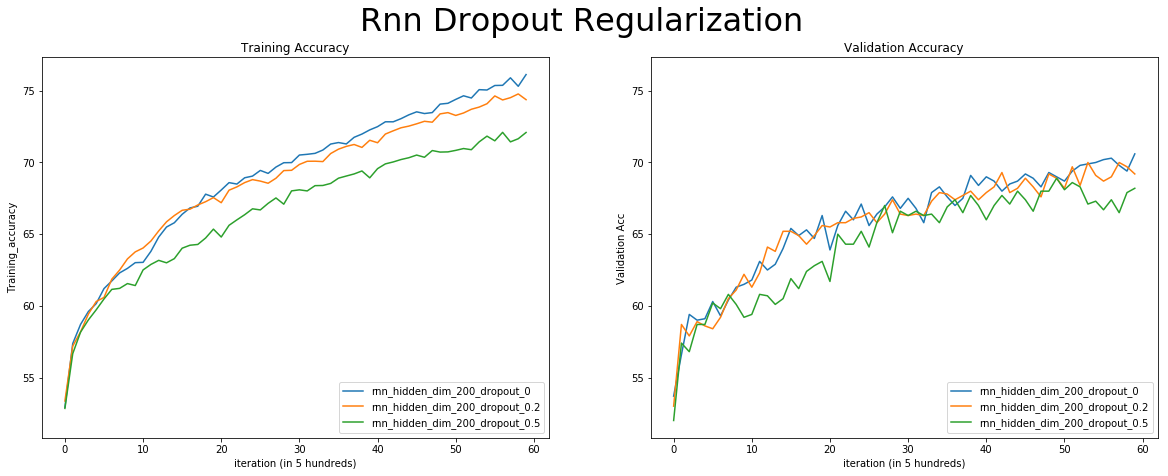

In [289]:
plot_acc_curve('dropout', rnn=True)

                                h_dim_100  h_dim_150  h_dim_200  h_dim_250  h_dim_300
After_10_epochs_validation_acc       69.4       68.6       69.7       70.6       69.1


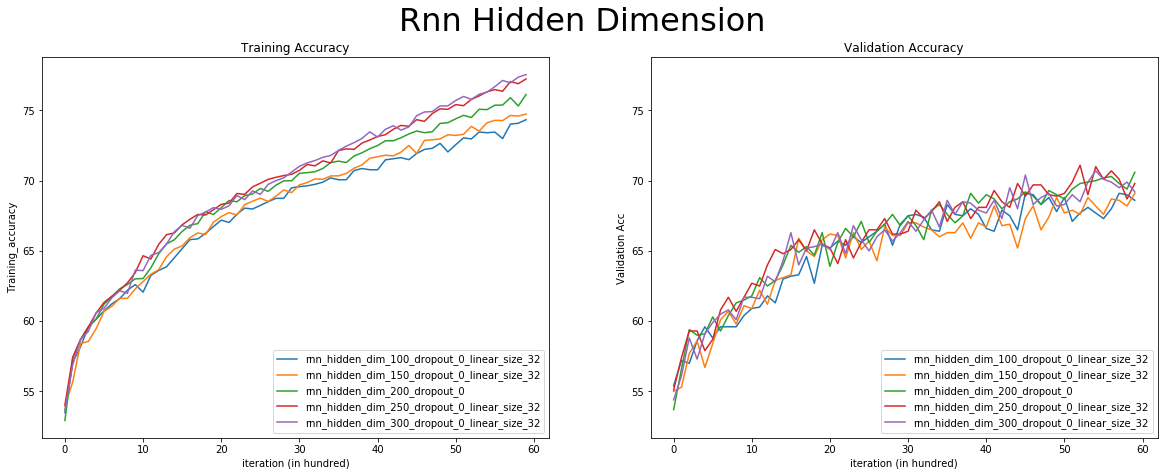

In [271]:
plot_acc_curve('hidden_dim', rnn=True)

                                linear_size_128  linear_size_32  linear_size_64
After_10_epochs_validation_acc             69.6            70.6            69.9


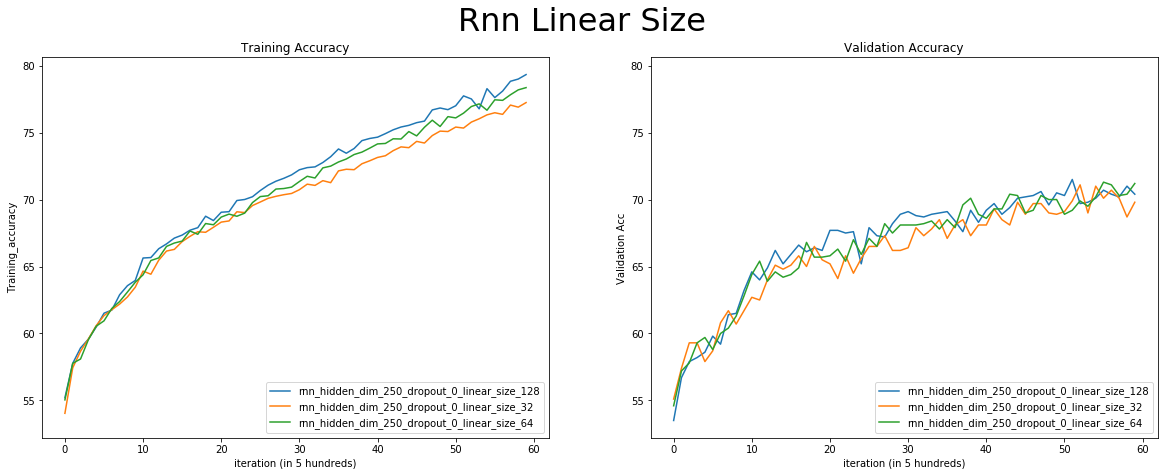

In [291]:
plot_acc_curve('linear_size', rnn=True)

## CNN

                                cnn_dropout_0.2  cnn_dropout_0.3  cnn_dropout_0.5  cnn_dropout_0
After_10_epochs_validation_acc             67.2             67.4             64.7           64.7


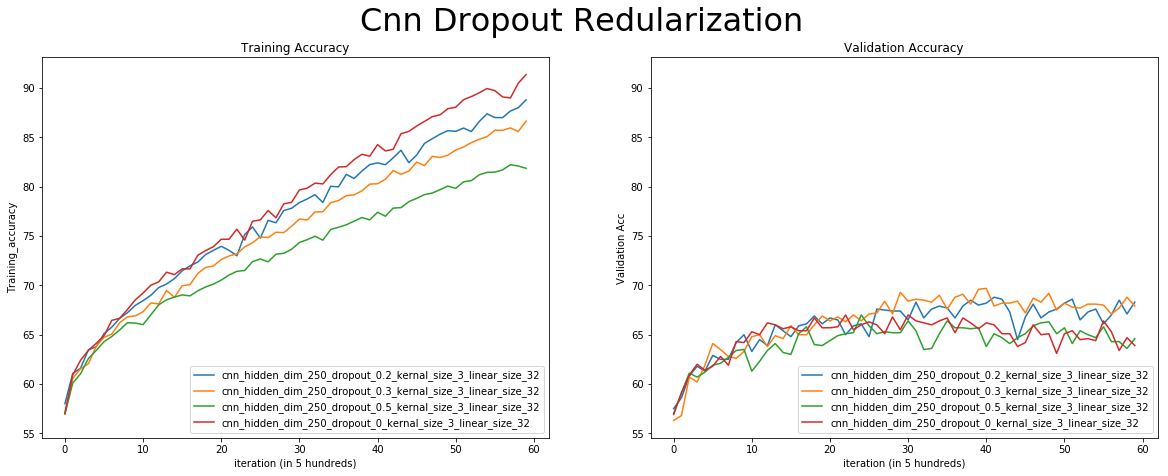

In [293]:
plot_acc_curve('dropout', rnn=False)

                                kernal_size_3_linear_size_32  kernal_size_4_linear_size_32  kernal_size_5_linear_size_32
After_10_epochs_validation_acc                          67.4                          67.7                          66.4


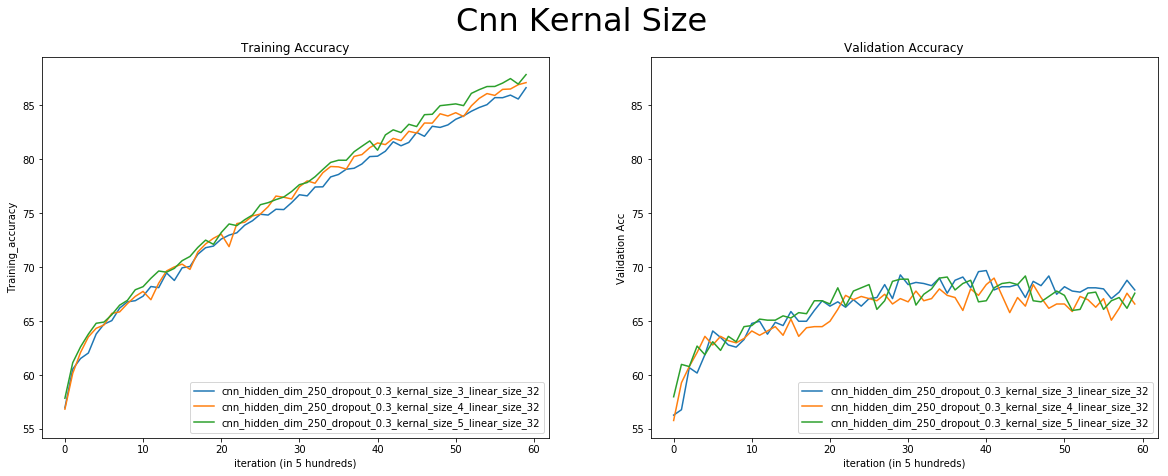

In [296]:
plot_acc_curve('kernal_size', rnn= False)

                                h_dim_200  h_dim_250  h_dim_300  h_dim_400
After_10_epochs_validation_acc       65.9       67.7       66.7       66.6


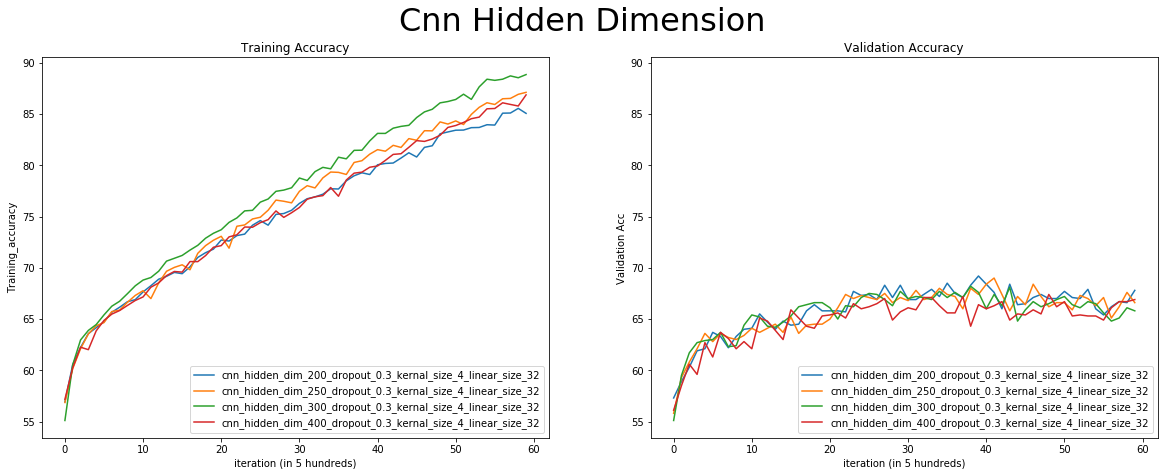

In [298]:
plot_acc_curve('hidden_dim', rnn=False)

# Best Validation Model

In [56]:
read_after_acc

{'rnn_hidden_dim_200_dropout_0': 69.7,
 'rnn_hidden_dim_200_dropout_0.2': 69.4,
 'rnn_hidden_dim_200_dropout_0.5': 66.6,
 'rnn_hidden_dim_300_dropout_0_linear_size_32': 69.1,
 'rnn_hidden_dim_100_dropout_0_linear_size_32': 69.4,
 'rnn_hidden_dim_150_dropout_0_linear_size_32': 68.6,
 'rnn_hidden_dim_250_dropout_0_linear_size_32': 70.6,
 'rnn_hidden_dim_250_dropout_0_linear_size_64': 69.9,
 'rnn_hidden_dim_250_dropout_0_linear_size_128': 69.6,
 'cnn_hidden_dim_250_dropout_0_kernal_size_3_linear_size_32': 64.7,
 'cnn_hidden_dim_250_dropout_0.2_kernal_size_3_linear_size_32': 67.2,
 'cnn_hidden_dim_250_dropout_0.5_kernal_size_3_linear_size_32': 64.7,
 'cnn_hidden_dim_250_dropout_0.3_kernal_size_3_linear_size_32': 67.4,
 'cnn_hidden_dim_250_dropout_0.3_kernal_size_4_linear_size_32': 67.7,
 'cnn_hidden_dim_250_dropout_0.3_kernal_size_5_linear_size_32': 66.4,
 'cnn_hidden_dim_200_dropout_0.3_kernal_size_4_linear_size_32': 65.9,
 'cnn_hidden_dim_300_dropout_0.3_kernal_size_4_linear_size_32': 66

In [69]:
best_setting_rnn = max(read_after_acc,  key=read_after_acc.get)
print('Best setting for rnn: {}'.format(best_setting_rnn))
print('RNN highest validation accuracy: {}'.format(read_after_acc.get(best_setting_rnn)))
print('\t')
best_setting_cnn = 'cnn_hidden_dim_250_dropout_0.3_kernal_size_4_linear_size_32'
print('Best setting for vnn: {}'.format(best_setting_cnn))
print('CNN highest validation accuracy: {}'.format(read_after_acc.get(best_setting_cnn)))

Best setting for rnn: rnn_hidden_dim_250_dropout_0_linear_size_32
RNN highest validation accuracy: 70.6
	
Best setting for vnn: cnn_hidden_dim_250_dropout_0.3_kernal_size_4_linear_size_32
CNN highest validation accuracy: 67.7


# Error Analysis

In [105]:
#find the index where prediction =/!= labels, set shuffle = False for validation dataloader
label_value, predicted_value = zip(*result)
diff=[]
indx2label = { 0: 'neutral', 1: 'entailment', 2: 'contradiction'}
for i in range(len(label_value)-1):
    diff_value = label_value[i]-predicted_value[i]
    diff+= list(diff_value)

correct_index = [i for i,val in enumerate(diff) if val==0][:3]
incorrect_index = [i for i,val in enumerate(diff) if val!=0][:3]

print('3 CORRECT predction on validation set')
print('\t')
for i in correct_index:
    print('True label is:', val_labels_indices[i], indx2label[val_labels_indices[i]])
    print('Premise: '+ val_premise[i])
    print('Hypothesis: ', val_hypothesis[i])
    print('\t')


3 CORRECT predction on validation set
	
True label is: 2 contradiction
Premise: Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
Hypothesis:  There are two women standing on the stage
	
True label is: 1 entailment
Premise: Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
Hypothesis:  Multiple people are on a subway together , with each of them doing their own thing .
	
True label is: 1 entailment
Premise: bicycles stationed while a group of people socialize .
Hypothesis:  People get together near a stand of bicycles .
	


In [118]:
print('3 INCORRECT predctions on validation set')
print('\t')
for i in incorrect_index:
    integer = i//32
    remainder = i%32
    print('Predicted Label: ', predicted_value[integer][remainder], indx2label[predicted_value[integer][remainder]])
    print('True Label:', val_labels_indices[i], indx2label[val_labels_indices[i]] )
    print('Premise: '+ val_premise[i])
    print('Hypothesis: ' + val_hypothesis[i])
    print('\t')


3 INCORRECT predctions on validation set
	
Predicted Label:  2 contradiction
True Label: 1 entailment
Premise: Two people are in a green forest .
Hypothesis: The forest is not dead .
	
Predicted Label:  0 neutral
True Label: 1 entailment
Premise: A large group of people stand outside on a road while people on a higher level look on at them .
Hypothesis: One group of people are watching what another group does .
	
Predicted Label:  1 entailment
True Label: 2 contradiction
Premise: Man in white shirt and blue jeans looking to the side while walking down a busy sidewalk .
Hypothesis: Man has a blue shirt on .
	


#  Evaluating on MultiNLI

In [123]:
import pandas as pd
df = pd.read_csv('snli_val.tsv', sep='\t')

In [128]:
genre_entail = df[df['label']=='entailment']
genre_contrad = df[df['label']=='contradiction']
genre_neutral = df[df['label']=='neutral']
def create_indicies(df):
    premise = df['sentence1']
    hypothesis = df['sentence2']
    label = df['label']
    labels = {'neutral': 0,'entailment':1, 'contradiction':2 }
    premise_indices = token2index_dataset(premise)
    hypothesis_indices = token2index_dataset(hypothesis)
    labels_indices = [labels[i] for i in label]
    return premise_indices, hypothesis_indices, labels_indices

In [129]:
pre_entail_idx, hyp_entail_idx, label_entail_idx = create_indicies(genre_entail)
pre_contra_idx, hyp_contra_idx, label_contra_idx = create_indicies(genre_contrad)
pre_neutral_idx, hyp_neutral_idx, label_neutral_idx = create_indicies(genre_neutral)


In [131]:
val_entail = SNLIData(pre_entail_idx, hyp_entail_idx, label_entail_idx)
val_entail_loader = torch.utils.data.DataLoader(dataset = val_entail,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

val_contradict = SNLIData(pre_contra_idx, hyp_contra_idx, label_contra_idx)
val_contradict_loader = torch.utils.data.DataLoader(dataset = val_contradict,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

val_neutral = SNLIData(pre_neutral_idx, hyp_neutral_idx, label_neutral_idx)
val_neutral_loader = torch.utils.data.DataLoader(dataset = val_neutral,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

## Use best model setting

## RNN

In [235]:
MultiNLI_acc={}
MultiNLI_acc['rnn_val_entail'] = test_rnn_model(val_entail_loader, model)[0]
MultiNLI_acc['rnn_val_contradict']  = test_rnn_model(val_contradict_loader, model)[0]
MultiNLI_acc['rnn_val_neutral']  = test_rnn_model(val_neutral_loader, model)[0]

In [240]:
MultiNLI_acc

{'rnn_val_entail': 47.73413897280967,
 'rnn_val_contradict': 34.9402281254571,
 'rnn_val_neutral': 52.9585798816568}

## CNN

In [237]:
MultiNLI_acc_cnn={}
MultiNLI_acc_cnn['cnn_val_entail'] = test_cnn_model(val_entail_loader, model)[0]
MultiNLI_acc_cnn['cnn_val_contradict']  = test_cnn_model(val_contradict_loader, model)[0]
MultiNLI_acc_cnn['cnn_val_neutral']  = test_cnn_model(val_neutral_loader, model)[0]

In [242]:
MultiNLI_acc_cnn

{'cnn_val_entail': 45.31722054380665,
 'cnn_val_contradict': 31.1365805598731,
 'cnn_val_neutral': 52.071005917159766}

In [243]:
df1 = pd.DataFrame.from_dict({**MultiNLI_acc, **MultiNLI_acc_cnn},orient='index')
df1.columns=['Val Acc']
df1.T

,rnn_val_entail,rnn_val_contradict,rnn_val_neutral,cnn_val_entail,cnn_val_contradict,cnn_val_neutral
Val Acc,47.734139,34.940228,52.95858,45.317221,31.136581,52.071006
